In [55]:
# Imports
import nltk
import csv
import re
import pandas as pd
import numpy as np
from pprint import pprint
import math
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [56]:

negations_dic = { "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
                "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
                "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
                "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
                "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have",
                "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
                "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
                "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
                "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are",
                "you've": "you have", "ve": "have", "favor":"favour", "favorite":"favourite", "color":"colour",
                "behavior": "behaviour", "labor": "labour", "neighbor": "neighbour", "flavor":"flavour"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

class Splitter(object):
    def __init__(self):
        self.nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer()
    def split(self, text):
        sentences = self.nltk_splitter.tokenize(text)
        tokenized_sentences = [self.nltk_tokenizer.tokenize(sent) for sent in sentences]
        return tokenized_sentences

class POSTagger(object):
    def __init__(self):
        pass
    def pos_tag(self, sentences):
        pos = [nltk.pos_tag(sentence) for sentence in sentences]
        pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
        return pos
    
splitter = Splitter()
tok = WordPunctTokenizer()
postagger = POSTagger()
stemmer = SnowballStemmer("english")


pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))


def review_cleaner(text):
#     print("one")
    soup = BeautifulSoup(text, 'lxml')
#     print("two")
    souped = soup.get_text()
#     print("three")
    stripped = re.sub(combined_pat, '', souped)
#     print("four")
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    lower_case=""
    for i in range(0,len(clean)):
        if text[i].isalpha():
            lower_case=lower_case+text[i].lower()
        elif text[i].isdigit():
            lower_case=lower_case
        else:
            lower_case=lower_case+text[i]
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    forpos= " ".join(words).strip()
    splitted_sentences = splitter.split(forpos)
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)
    altered_text=""
    for sentences in pos_tagged_sentences:
        for word in sentences:
            v=word[2]
            for val in v:
                if (val=="JJ" or val=="JJR" or val=="JJS" or val=="VB" or val=="VBD" or val=="VBG"
                    or val=="VBN" or val=="VBP" or val=="VBZ" or val=="RB" or val=="RBR" or val=="RBS" ):
                    altered_text=altered_text+stemmer.stem(word[0])+" "
    return altered_text

In [113]:
# Store amazon reviews file in pandas dataframes
df = pd.read_csv("amazonmusical_reviews.csv")
df.drop(['sno','reviewerID','asin','reviewerName','helpful__001','helpful__002','overall','summary',
            'unixReviewTime','reviewTime','label'],axis=1,inplace=True)
print(df.shape)
print(df.rating.value_counts())
df.head(10)

(6000, 2)
4    3598
0    1226
2    1176
Name: rating, dtype: int64


,reviewText,rating
0,this box is very well made and will last a lon...,4
1,I've bought a half dozen of these to keep in a...,4
2,It does what its supposed to. I really like th...,4
3,I would recommend the D'Addario Prelude violin...,4
4,I have seven of these that I use on my Ibanez ...,4
5,I purchased this wax for a brand new guitar to...,4
6,"This product is great, I use it after every se...",4
7,"Yeah, i bought these for my friend' s band and...",4
8,I got this mic to record a vocal podcast and s...,4
9,This is a terrific product. While the price m...,4


In [114]:

df.loc[((df["rating"]==2)),'rating']=1
df.loc[((df["rating"]==4)),'rating']=2
print(df.rating.value_counts())
df.head(10)


2    3598
0    1226
1    1176
Name: rating, dtype: int64


,reviewText,rating
0,this box is very well made and will last a lon...,2
1,I've bought a half dozen of these to keep in a...,2
2,It does what its supposed to. I really like th...,2
3,I would recommend the D'Addario Prelude violin...,2
4,I have seven of these that I use on my Ibanez ...,2
5,I purchased this wax for a brand new guitar to...,2
6,"This product is great, I use it after every se...",2
7,"Yeah, i bought these for my friend' s band and...",2
8,I got this mic to record a vocal podcast and s...,2
9,This is a terrific product. While the price m...,2


In [115]:
# Create clean review file 
df=df.fillna("are")
clean_review_texts = np.empty([1, 2], dtype=object)
for i in range(0,len(df)):
    clean_review_texts=np.append(clean_review_texts, np.array([[review_cleaner(df.iloc[i]['reviewText']),df.iloc[i]['rating']]]), axis=0)
clean_review_texts=np.delete(clean_review_texts, 0, 0)
clean_df = pd.DataFrame(clean_review_texts,columns=['text','target'])    
clean_df.to_csv('amazonmusical_clean_review.csv', encoding='utf-8')

In [116]:
from sklearn.feature_extraction.text import CountVectorizer

my_df = pd.read_csv('amazonmusical_clean_review.csv',index_col=0)
cvec = CountVectorizer(dtype='float32')
#cvec.fit(my_df.text)
my_df=my_df.fillna("are")
cvec.fit_transform(my_df['text'].values.astype('U'))
l=len(cvec.get_feature_names())
print("Number of features: ",l)
neg_doc_matrix = cvec.transform(my_df[my_df.target ==0 ].text)
neu_doc_matrix = cvec.transform(my_df[my_df.target ==1 ].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target ==2 ].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
neu_tf = np.sum(neu_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray((neg_tf)))
neu = np.squeeze(np.asarray((neu_tf)))
pos = np.squeeze(np.asarray((pos_tf)))

term_freq_df = pd.DataFrame([neg,neu,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()
term_freq_df.columns = ['negative','neutral','positive']
term_freq_df['total'] = term_freq_df['negative'] +term_freq_df['neutral'] +term_freq_df['positive']
#document_matrix = cvec.transform(my_df.text)
term_freq_df.to_csv('amazonmusical_term_freq.csv',encoding='utf-8')

term_freq_df_new = pd.read_csv('amazonmusical_term_freq.csv',index_col=0)
#print(term_freq_tfidf)
lexicon_df = pd.DataFrame([neg,neu,pos],columns=cvec.get_feature_names()).transpose()
lexicon_df.columns = ['negative', 'neutral','positive']
for i in range(0,l):
    tot=term_freq_df_new.iloc[i]['total']
    nn=term_freq_df_new.iloc[i]['negative']
    nu=term_freq_df_new.iloc[i]['neutral']
    ps=term_freq_df_new.iloc[i]['positive']
    if nn==0:
        lexicon_df.iloc[i]['negative']=0
    elif nn==tot:
        lexicon_df.iloc[i]['negative']=2.5*nn
    else:
        lexicon_df.iloc[i]['negative']=1/(math.log((tot/nn),10))
    
    if nu==0:
        lexicon_df.iloc[i]['neutral']=0
    elif nu==tot:
        lexicon_df.iloc[i]['neutral']=2.5*nu
    else:
        lexicon_df.iloc[i]['neutral']=1/(math.log((tot/nu),10))
     
    if ps==0:
        lexicon_df.iloc[i]['positive']=0
    elif ps==tot:
        lexicon_df.iloc[i]['positive']=2.5*ps
    else:
        lexicon_df.iloc[i]['positive']=1/(math.log((tot/ps),10))
        #print(1/(math.log((tot/ps),10)))
        #print(float(term_freq_tfidff.iloc[i]['positive']))

lexicon_df.to_csv('amazonmusical_lexicon.csv',encoding='utf-8') 


Number of features:  4957


In [117]:
createfeed=pd.read_csv('amazonmusical_lexicon.csv',index_col=0)
columns=["Sno","freq_neg","freq_neu","freq_pos","overall"]
# my_df=my_df.fillna("are")
ok=len(my_df)
#print(my_df.isnull())
feature_values=[0,0,0]
#print(feature_values)

with open('amazonmusical_feed.csv','w') as myfile:
    wr = csv.writer(myfile,quoting=csv.QUOTE_NONE)
    wr.writerow(columns)
    for i in range(0,ok):
        if i%(ok//2)==0:
            print(i)
        feature_values=[0,0,0]
        text_for_comparison = my_df.iloc[i]['text']
        if text_for_comparison not in (None, " ","are"):
            words= text_for_comparison.split()
            for j in range(0,len(words)):
                if ('nan' not in words) & ('null' not in words) :
                    feature_values = np.add(feature_values,[createfeed.loc[words[j]][0],createfeed.loc[words[j]][1],createfeed.loc[words[j]][2]])
                else:
                    feature_values = np.add(feature_values,[0,0,0])
                #print(feature_values)
            feature_values = feature_values.tolist()
            #print(feature_values)
            feature_values.insert(0, i)
#             new_lab=int(my_df.iloc[i]['label']/2)
            new_lab=my_df.iloc[i]['target']
            feature_values.insert(4, new_lab)
            wr.writerow(feature_values)   


0
3000


In [118]:
print(ok)

6000


In [119]:
import numpy as np
import keras
import keras.utils
from keras.utils import to_categorical
with open('amazonmusical_feed.csv') as f:
    content = f.readlines()
lines = np.array(content) 
num_of_instances = lines.size
print(num_of_instances)
print(lines[0])

6000
Sno,freq_neg,freq_neu,freq_pos,overall



In [120]:
x_all, y_all = [], []
for i in range(1, num_of_instances):
    val = [0, 0, 0]
    s, val[0], val[1], val[2] ,label = lines[i].split(",")
        
    #print(newlabel)
    final_val = np.array(val, 'float32')
    class_label = keras.utils.to_categorical(label,3)
    #class_label=class_label[0:3]
    y_all.append(class_label)
    x_all.append(final_val)

In [121]:
x_all = np.array(x_all)
print(np.shape(x_all))
y_all = np.array(y_all)
print(np.shape(y_all))
print(y_all)
print(len(x_all))

(5999, 3)
(5999, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
5999


In [122]:
from random import shuffle
ind_list = [i for i in range(len(x_all))]
shuffle(ind_list)
x_all  = x_all[ind_list,]
y_all = y_all[ind_list,]

In [123]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

modelsentif=Sequential()

modelsentif.add(Dense(8,input_shape=(3,)))
modelsentif.add(Activation("sigmoid"))
# modelsentif.add(Dropout(0.2))
modelsentif.add(Dense(3))
modelsentif.add(Activation("softmax"))

In [124]:
modelsentif.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

histsentif = modelsentif.fit(x_all, y_all, epochs=40, batch_size=128, validation_split=0.25, verbose=1)

Train on 4499 samples, validate on 1500 samples
Epoch 1/40
4499/4499 [==============================] - 1s 270us/step - loss: 1.2164 - acc: 0.1718 - val_loss: 1.1363 - val_acc: 0.1580
Epoch 2/40
4499/4499 [==============================] - 0s 20us/step - loss: 1.0608 - acc: 0.3296 - val_loss: 0.9968 - val_acc: 0.7080
Epoch 3/40
4499/4499 [==============================] - 0s 19us/step - loss: 0.9498 - acc: 0.7099 - val_loss: 0.8944 - val_acc: 0.7300
Epoch 4/40
4499/4499 [==============================] - 0s 24us/step - loss: 0.8726 - acc: 0.7135 - val_loss: 0.8252 - val_acc: 0.7373
Epoch 5/40
4499/4499 [==============================] - 0s 22us/step - loss: 0.8167 - acc: 0.7124 - val_loss: 0.7757 - val_acc: 0.7387
Epoch 6/40
4499/4499 [==============================] - 0s 22us/step - loss: 0.7757 - acc: 0.7144 - val_loss: 0.7353 - val_acc: 0.7373
Epoch 7/40
4499/4499 [==============================] - 0s 23us/step - loss: 0.7293 - acc: 0.7164 - val_loss: 0.6741 - val_acc: 0.7260
Epoch 

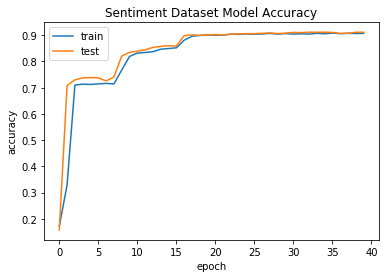

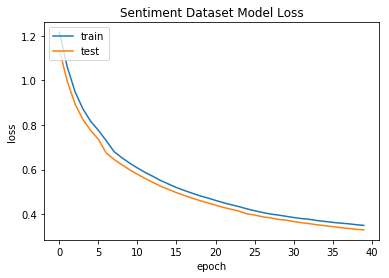

In [125]:
# summarize history for accuracy
plt.plot(histsentif.history['acc'])
plt.plot(histsentif.history['val_acc'])
plt.title('Sentiment Dataset Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histsentif.history['loss'])
plt.plot(histsentif.history['val_loss'])
plt.title('Sentiment Dataset Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [126]:
# serialize model to JSON
modelsentif_json = modelsentif.to_json()
with open("modelamazonmusic.json", "w") as json_file:
    json_file.write(modelsentif_json)
# serialize weights to HDF5
modelsentif.save_weights("modelamazonmusic.h5")
print("Saved model to disk")


from keras.models import model_from_json
# load json and create model
json_file = open('modelamazonmusic.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelamazonmusic.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [127]:
from sklearn.metrics import classification_report, confusion_matrix
pred_list = []; actual_list = []
predictions = loaded_model.predict(x_all)
for i in predictions:
    pred_list.append(np.argmax(i))
for i in y_all:
    actual_list.append(np.argmax(i))
cnf_matrix=confusion_matrix(actual_list, pred_list)

In [128]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(len(classes))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1118   44   64]
 [  52  904  220]
 [  66   97 3434]]
3


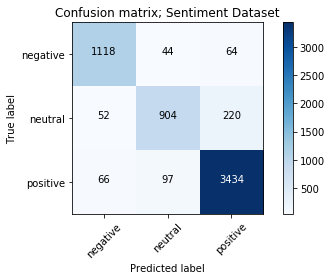

In [129]:
# Plot non-normalized confusion matrix
class_names =['negative','neutral','positive']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix; Sentiment Dataset')
plt.show()

In [136]:
# Test model on actual input
import pandas as pd
createfeed=pd.read_csv('amazonmusical_lexicon.csv',index_col=0)
feature_values=[0,0,0]
str = "The drums were torned and defective"
str_result =  review_cleaner(str)
words= str_result.split()
words.insert(0, '')
words.insert(0, '')
print(words)
for j in range(2,len(words)):
    try:
        if (words[j-1]=="not" and words[j-2]!="not") or (words[j-1]!="not" and words[j-2]=="not"):
            feature_values = np.add(feature_values,[createfeed.loc[words[j]][2],createfeed.loc[words[j]][1],createfeed.loc[words[j]][0]])
        else:
            feature_values = np.add(feature_values,[createfeed.loc[words[j]][0],createfeed.loc[words[j]][1],createfeed.loc[words[j]][2]])
    except:
        continue
feature_values = feature_values.tolist()
test_case = np.array(feature_values)

checker = []
checker.append(test_case)
checker = np.array(checker)

custom = modelsentif.predict(checker)
print(custom[0])

# Order: negative, neutral, positive

['', '', 'were', 'torn', 'defect']
[0.81265867 0.14221533 0.04512606]
